In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Data preparing

In [ ]:
# Data downloaded

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, "train")
validation_dir = os.path.join(PATH,"validation")

BATCH_SIZE=32
IMG_SIZE=(160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

68616192/68606236 [==============================] - 1s 0us/step
Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


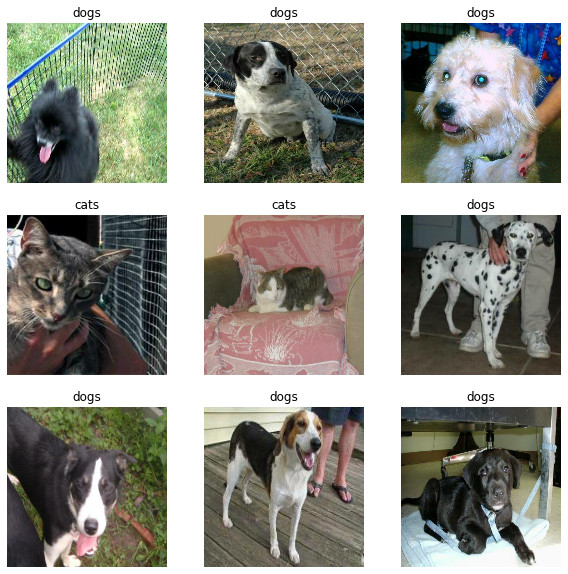

In [ ]:
# Visualize images
class_names = train_dataset.class_names
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis(False)  

In [ ]:
# Split the validation dataset for test purpose

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


# Configure the dataset performance

Use buffered prefetching to load images from disk without having I/O become blocking

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)


# Use data augmentation

When you dont have a large image dataset, its a good practice to artificially introduce sample diversity by applying random, yet realistic, thnsformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting. You ca learn more about data augmentation in this tutorial

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2)                                     
])

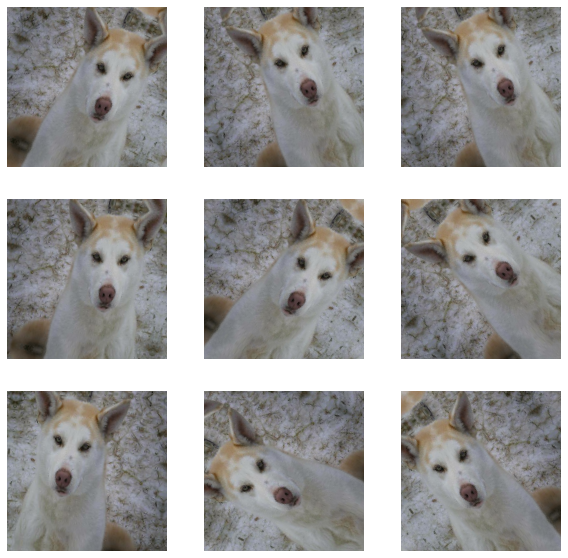

In [ ]:
# Let's repeatedly apply these layers to the same image and see the results

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10,10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    augmented_image = data_augmentation(tf.expand_dims(first_image,0))
    plt.imshow(augmented_image[0]/255.)
    plt.axis(False)

In [ ]:
# Rescale pixel values
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = layers.Rescaling(1./127.5, offset=-1)
# Rescale to [-1, 1]

# Create base model from the pre-trained convNets

In [ ]:
# Create base model from the pre-trained model MobileNetV2

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights="imagenet")

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# Free the convolutional base
base_model.trainable=False

In [ ]:
# Let's see what it does to an example batch of images
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(image_batch.shape)
print(feature_batch.shape)

# It's converts each 160x160x3 image into 5x5x1280

(32, 160, 160, 3)
(32, 5, 5, 1280)


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
# Add a classification head
global_average_layer = layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
# Create model
inputs = layers.Input(shape=IMG_SHAPE, name="input_shape")
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = layers.Dropout(0.2)(x)

outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
# Compile the model
base_learing_rate = 0.0001
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(lr=base_learing_rate),
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_shape (InputLayer)     [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [ ]:
# Train model for 10 epochs
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 4s 64ms/step - loss: 0.9047 - accuracy: 0.3663


In [ ]:
print(f"Initial loss {loss0:.2f}")
print(f"Initial accuracy {accuracy0:.2f}")

Initial loss 0.90
Initial accuracy 0.37


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data =validation_dataset)

Epoch 1/10
63/63 [==============================] - 10s 94ms/step - loss: 0.7336 - accuracy: 0.5485 - val_loss: 0.6074 - val_accuracy: 0.6745
Epoch 2/10
63/63 [==============================] - 6s 90ms/step - loss: 0.5592 - accuracy: 0.7025 - val_loss: 0.4407 - val_accuracy: 0.7908
Epoch 3/10
63/63 [==============================] - 6s 88ms/step - loss: 0.4372 - accuracy: 0.7835 - val_loss: 0.3271 - val_accuracy: 0.8601
Epoch 4/10
63/63 [==============================] - 6s 89ms/step - loss: 0.3698 - accuracy: 0.8335 - val_loss: 0.2598 - val_accuracy: 0.9084
Epoch 5/10
63/63 [==============================] - 6s 89ms/step - loss: 0.3178 - accuracy: 0.8675 - val_loss: 0.2186 - val_accuracy: 0.9208
Epoch 6/10
63/63 [==============================] - 6s 88ms/step - loss: 0.2892 - accuracy: 0.8725 - val_loss: 0.1887 - val_accuracy: 0.9344
Epoch 7/10
63/63 [==============================] - 6s 88ms/step - loss: 0.2621 - accuracy: 0.8920 - val_loss: 0.1711 - val_accuracy: 0.9369
Epoch 8/10
6

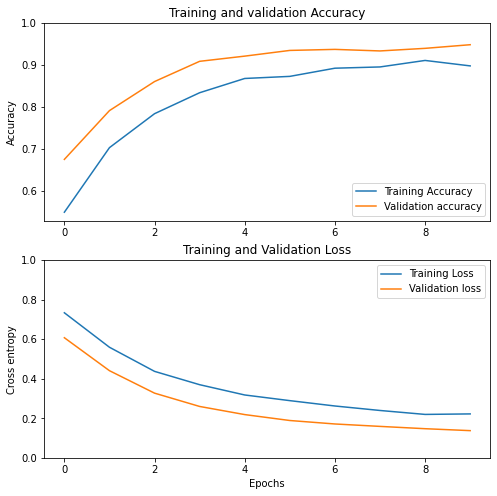

In [ ]:
# Learning Curves
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(8,8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()),1])
plt.title("Training and validation Accuracy")


plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.ylabel("Cross entropy")
plt.ylim([0,1.0])
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.show()

# Fine tuning

In [ ]:
# Unfreeze the top layers of the model
base_model.trainable = True

# Freeze all the layers except the last 100 layer
for layer in base_model.layers[:100]:
  layer.trainable = False

In [ ]:
# Recompile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(lr=base_learing_rate/10),
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_shape (InputLayer)     [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [ ]:
# Contune training the model
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         validation_data=validation_dataset,
                         initial_epoch=history.epoch[-1])

Epoch 10/20
63/63 [==============================] - 14s 130ms/step - loss: 0.1468 - accuracy: 0.9360 - val_loss: 0.0621 - val_accuracy: 0.9839
Epoch 11/20
63/63 [==============================] - 7s 113ms/step - loss: 0.1232 - accuracy: 0.9485 - val_loss: 0.0499 - val_accuracy: 0.9851
Epoch 12/20
63/63 [==============================] - 7s 111ms/step - loss: 0.0973 - accuracy: 0.9600 - val_loss: 0.0430 - val_accuracy: 0.9851
Epoch 13/20
63/63 [==============================] - 7s 112ms/step - loss: 0.0996 - accuracy: 0.9560 - val_loss: 0.0447 - val_accuracy: 0.9851
Epoch 14/20
63/63 [==============================] - 7s 112ms/step - loss: 0.0778 - accuracy: 0.9710 - val_loss: 0.0454 - val_accuracy: 0.9901
Epoch 15/20
63/63 [==============================] - 7s 113ms/step - loss: 0.0796 - accuracy: 0.9645 - val_loss: 0.0435 - val_accuracy: 0.9740
Epoch 16/20
63/63 [==============================] - 7s 111ms/step - loss: 0.0765 - accuracy: 0.9680 - val_loss: 0.0359 - val_accuracy: 0.993

In [ ]:
initial_epochs

10

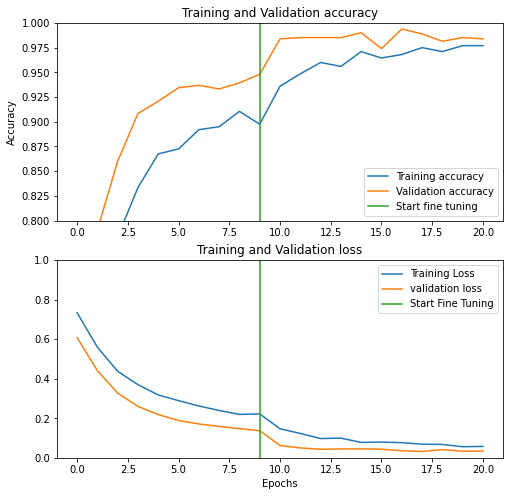

In [ ]:
# acc += history_fine.history['accuracy']
# val_acc += history_fine.history['val_accuracy']

# loss  += history_fine.history["loss"]
# val_loss += history_fine.history["val_loss"]

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.title("Training and Validation accuracy")
plt.ylabel("Accuracy")
plt.plot(acc, label="Training accuracy")
plt.plot(val_acc, label="Validation accuracy")
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label="Start fine tuning")
plt.legend(loc="lower right")
plt.ylim([0.8,1])

plt.subplot(2,1,2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="validation loss")
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
plt.legend(loc="upper right")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.show();

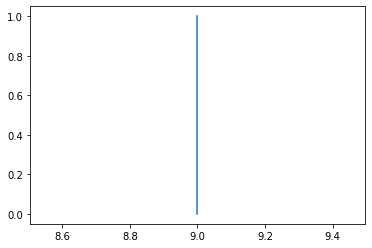

In [ ]:
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim())

In [ ]:
# Evaluating and predictions
loss, accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {accuracy}")

6/6 [==============================] - 1s 60ms/step - loss: 0.0549 - accuracy: 0.9740
Test accuracy: 0.9739583134651184


Predictions:
[0 0 0 0 1 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 0 1 1 0 1 1 1 0 0]
Label:
[0 0 0 0 1 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 0 1 1 0 1 1 1 0 0]


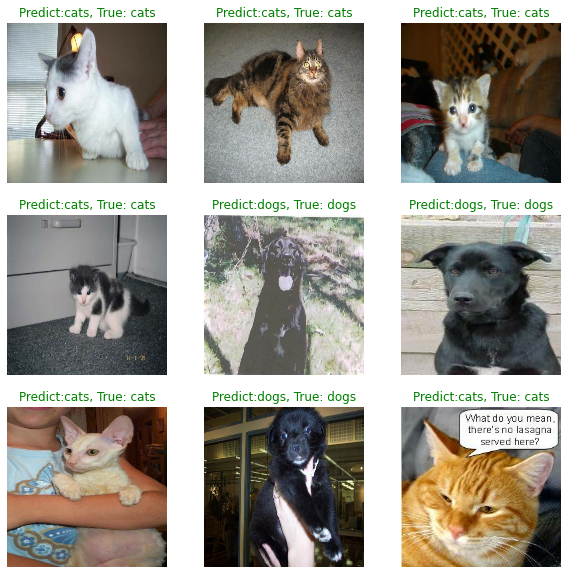

In [ ]:
# Retrieve a batch of images fron the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print(f"Predictions:\n{predictions.numpy()}")
print(f"Label:\n{label_batch}")

plt.figure(figsize=(10,10))
for i in range(9):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image_batch[i].astype("uint8"))
  if class_names[predictions[i]] == class_names[label_batch[i]]:
    color = "g"
  else:
    color = "r"
  plt.title(f"Predict:{class_names[predictions[i]]}, True: {class_names[label_batch[i]]}", color=color)
  plt.axis("off")

In [ ]:
classlabel_batch[i]

0